#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.model_selection import TimeSeriesSplit

### Загрузка и первичное знакомство с данными

Загрузим данные и установим индекс таблицы равным столбцу Datetime. 

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим предварительную информацию.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Убедимся, что данные расположены в хронологическом прорядке.

In [5]:
df.index.is_monotonic

True

**Вывод** 

- Загрузили данные установили индекс таблицы равным столбцу Datetime.
- Убедились в отсутствии пропусков. 
- Убедились что даты расположены в хронологическом порядка.

Данные пригодны для дальнейшего исследования, но временные интервалы 10 мин, в дальнейшем приведём их к 1 часу.

### Ресемплирование данных по одному часу

Выполним ресемплирование данных по одному часу.

In [6]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

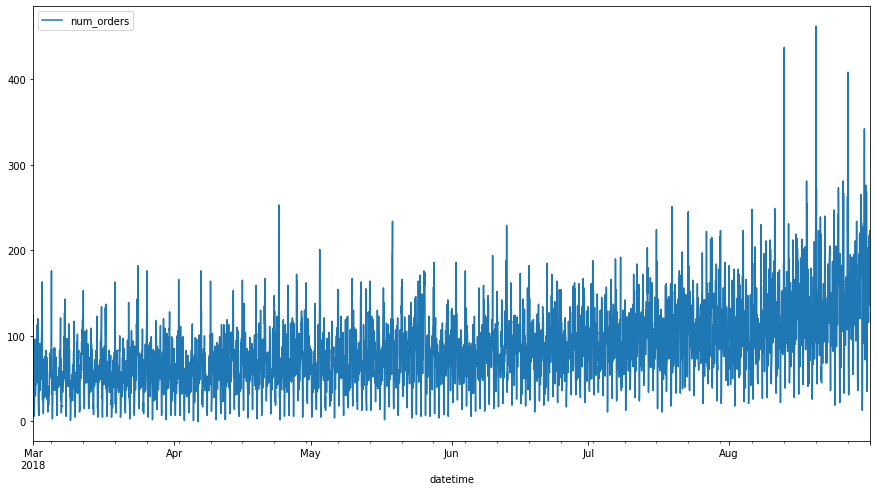

In [7]:
df.plot(figsize=(15, 8))

**Вывод**

- Провели ресемплирование данных.

Видны достаточно сильные колебания, но данные готовы для дальнейшего анализа и моделирования.

## Анализ

Проанализируем имеющиеся у нас данные, для этого применим указанные ниже инструмены.

In [8]:
df_analysis = df[['num_orders']].copy()

### Скользящее среднее

In [9]:
df_analysis['rolling_mean'] = df_analysis.rolling(24).mean()

<AxesSubplot:xlabel='datetime'>

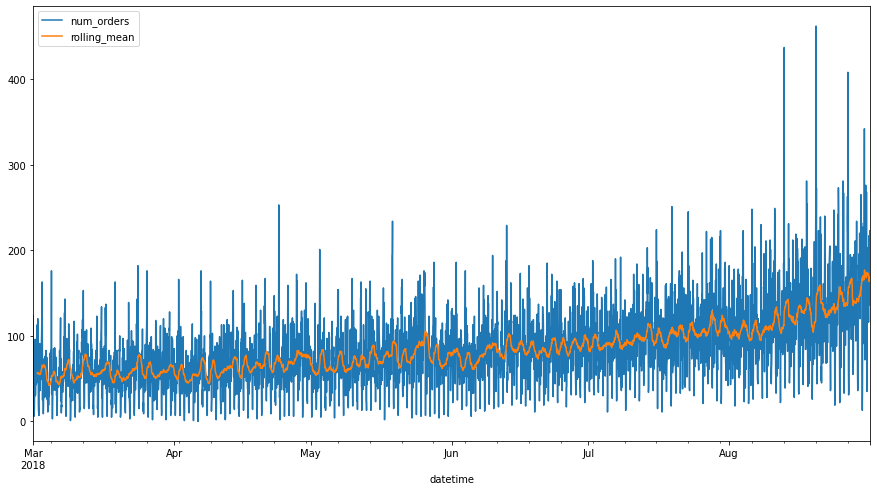

In [10]:
df_analysis.plot(figsize=(15, 8))

**Вывод**

Как видно из графика, скользящее среднее возростает от весенних месяцев к лету, по скольку это такси в аэрапортах, возможно это связано с сезоном отпусков и увеличением рейсов в летний период.

### Тренды и сезонность

In [11]:
df_analysis = df_analysis.drop('rolling_mean', axis=1)

Декомпозируем данные

In [12]:
decomposed = seasonal_decompose(df_analysis)

Для начала посмотрим общий тренд.

Text(0.5, 1.0, 'Trend')

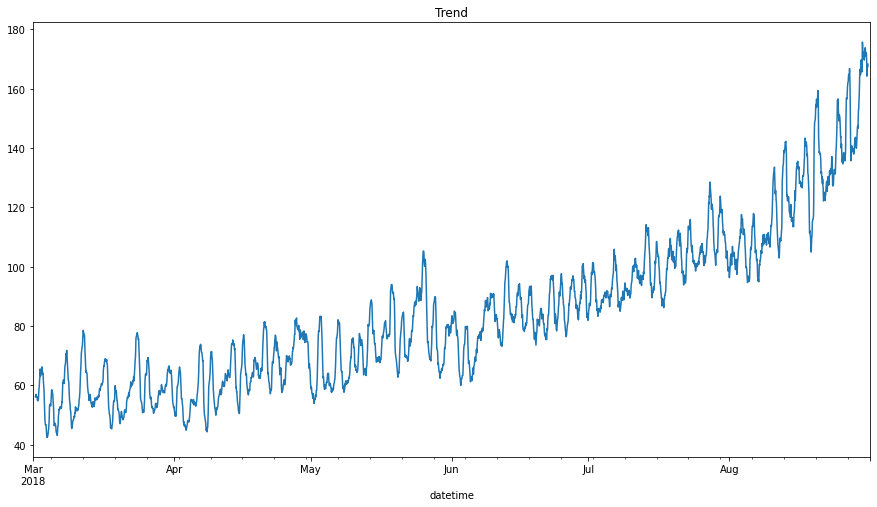

In [13]:
plt.figure(figsize=(15, 8))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')



Теперь посмотрим график сезонности.

Text(0.5, 1.0, 'Seasonality')

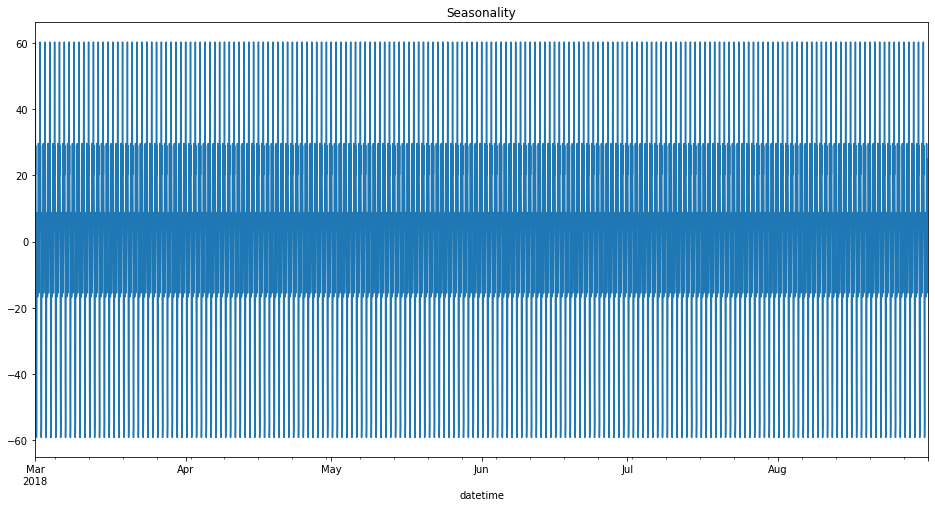

In [14]:
plt.figure(figsize=(16, 8))
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')


Теперь остатки.

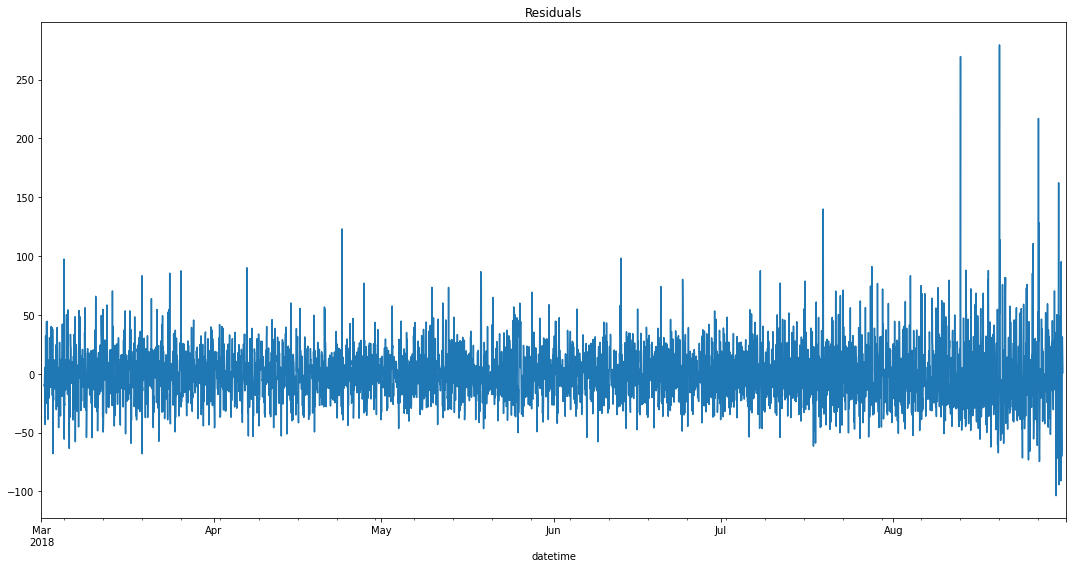

In [15]:
plt.figure(figsize=(15, 8))
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По скольку сезонность у нас меньше года, посмотрим на небольшом периоде (2 дня).

Text(0.5, 1.0, 'Seasonality')

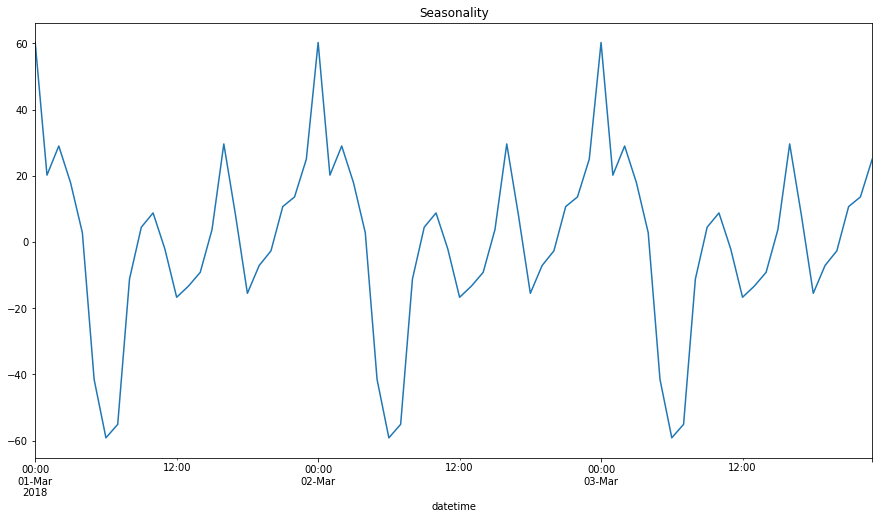

In [16]:
plt.figure(figsize=(15, 8))
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')


Теперь посмотрим недельную сезонность.

Для начала сделаем новую ресемпликацию: по дням.

In [17]:
df_analysis_day = df_analysis.resample('1D').sum()

Заново сделаем декомпозицию

In [18]:
decomposed_day = seasonal_decompose(df_analysis_day)

Для наглядности сделаем график по трёхнедельному срезу.

Text(0.5, 1.0, 'Seasonality')

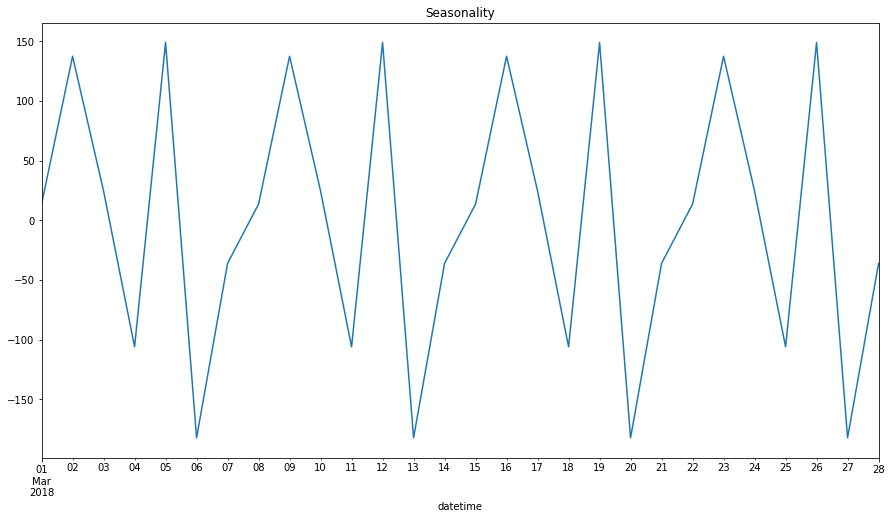

In [19]:
plt.figure(figsize=(15, 8))
decomposed_day.seasonal['2018-03-01':'2018-03-28'].plot(ax=plt.gca())
plt.title('Seasonality')

**Вывод**

- Мы видим возрастающий тренд от марта к августу.
- Присутствует "сезонность" в рамках дня всплеск активности наблюдается в районе 00:00 часов, после чего идёт спад примерно до 6:00 после чего наблюдается рост с пиками в районе 12:00 и 18:00.
- Присутствует недельная сезонность: мы видим пики активности по понедельникам и пятницам, при этом наблюдается спады активности по вторникам и воскресеньям.
- Остатки не объяснимы.

### Разности временного ряда

Посмотрим разности временного ряда.

<AxesSubplot:xlabel='datetime'>

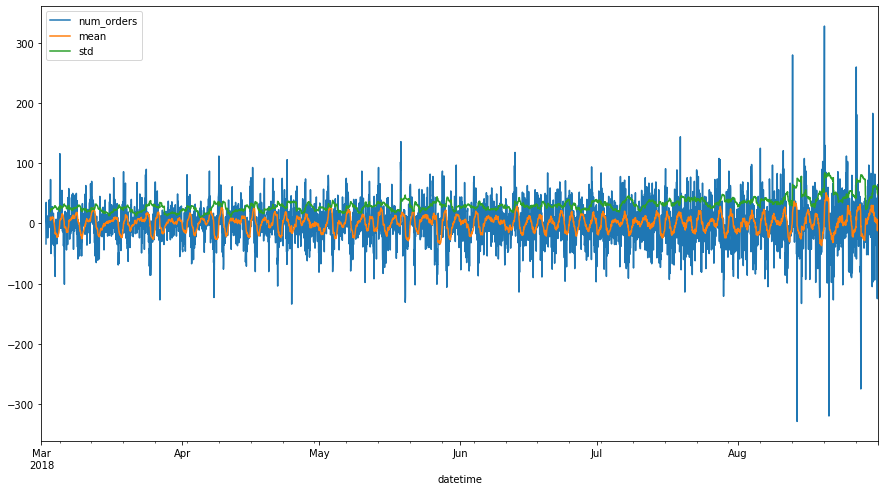

In [20]:
df_analysis = df_analysis - df_analysis.shift(24)
df_analysis['mean'] = df_analysis['num_orders'].rolling(24).mean()
df_analysis['std'] = df_analysis['num_orders'].rolling(24).std()
df_analysis.plot(figsize=(15, 8))

## Обучение

### Создание признаков

In [21]:
def make_features(data):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    
    return data


In [22]:
make_features(df)

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4
...,...,...,...
2018-08-31 19:00:00,136,4,19
2018-08-31 20:00:00,154,4,20
2018-08-31 21:00:00,159,4,21


In [23]:
df['lag_24'] = df['num_orders'].shift(24)
df['lag_48'] = df['num_orders'].shift(48)
df['lag_72'] = df['num_orders'].shift(72)
df['lag_96'] = df['num_orders'].shift(96)
df['lag_120'] = df['num_orders'].shift(120)
df['lag_144'] = df['num_orders'].shift(144)
df['lag_168'] = df['num_orders'].shift(168)

In [24]:
df['rolling_mean'] = df['num_orders'].shift().rolling(168).mean()

In [25]:
df = df.dropna()

**Вывод**

Создали признаки: 
- день недели
- час
- скользящее среднее с окном 168(неделя)
- смещения 7 признаков (кратно суткам)

### Разделение данных на тренировочную, валидационную и тестовую выборки

In [26]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)


In [27]:
print(train.index.min(), train.index.max(), 'Тренировочная выборка')
print(test.index.min(), test.index.max(), 'Тестовая выборка')

2018-03-08 00:00:00 2018-08-14 06:00:00 Тренировочная выборка
2018-08-14 07:00:00 2018-08-31 23:00:00 Тестовая выборка


In [28]:
print(train.shape, 'Тренировочная выборка')
print(test.shape, 'Тестовая выборка')

(3823, 11) Тренировочная выборка
(425, 11) Тестовая выборка


Удалим получившиеся при создании признаков пропуски.

In [29]:
features_train  = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [30]:
print(features_train.shape, 'Тренировочная выборка')
print(features_test.shape, 'Тестовая выборка')

(3823, 10) Тренировочная выборка
(425, 10) Тестовая выборка


**Вывод**

Получили тренировочную и тестовую выборки.

### Модель линейной регрессии

In [31]:
tscv = TimeSeriesSplit(n_splits=5)

In [32]:
model = LinearRegression()

In [33]:
scores_list = cross_val_score(estimator=model, 
                              X=features_train, 
                              y=target_train, 
                              cv=tscv,  
                              scoring='neg_root_mean_squared_error')

val_score = -1*scores_list.mean()

In [34]:
print(f' RMSE модели линейной регрессии по кросс-валидации равно {val_score}')

 RMSE модели линейной регрессии по кросс-валидации равно 22.919374623152528


**Вывод**

Удалось получить для модели линейной регрессии RMSE по кросс-валидации 22,91. 

### Модель случайного леса

In [35]:
model_RandomForest = RandomForestRegressor(random_state=42) 
model_RandomForest.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [36]:
param_search = {
    'n_estimators': range(1, 121,10),
    'max_depth': range (1, 11)
}

gsearch_Forest = GridSearchCV(estimator= model_RandomForest,
                              cv=tscv,
                              param_grid=param_search,
                              scoring = 'neg_root_mean_squared_error')
gsearch_Forest.fit(features_train, target_train)
print('Оптимальные параметры: ', gsearch_Forest.best_params_)
print(f'RMSE модели случайного по кросс-валидации равно {-1*gsearch_Forest.best_score_}')

Оптимальные параметры:  {'max_depth': 6, 'n_estimators': 91}
RMSE модели случайного по кросс-валидации равно 23.63961379251835


**Вывод**

Удалось получить для модели случайного леса RMSE на кросс-валидации 23.63 с гиперпараметрами  'max_depth'= 6 и 'n_estimators'= 91. 

###  Модель градиендный бустинг CatBoost

In [37]:
catBoost = CatBoostRegressor(loss_function='RMSE', eval_metric = 'RMSE')


In [38]:
param_search_1 = [{'depth' : range (3, 8),
                'learning_rate' : [0.2],
                'iterations' : range(1, 301, 30),
                'verbose' : [False]
               }]

In [39]:
cat = GridSearchCV(estimator=catBoost,
                  cv=tscv,
                  param_grid=param_search_1,
                  scoring = 'neg_root_mean_squared_error')
cat.fit(features_train, target_train)
print('Оптимальные параметры: ', cat.best_params_)
print(f'RMSE модели CatBoost по кросс-валидации равно {-1*cat.best_score_}')



Оптимальные параметры:  {'depth': 6, 'iterations': 31, 'learning_rate': 0.2, 'verbose': False}
RMSE модели CatBoost по кросс-валидации равно 23.361063146186275


**Вывод**

Удалось получить для модели CatBoost RMSE на кросс-валидации 23.36 с гиперпараметрами 'depth'= 6, 'iterations'= 31.

###  Общий вывод

В результате исследования было обучено 3 модели:
- модель линейной регрессии: удалось получить RMSE 22.91
- модель случайного леса: удалось получить RMSE 23.63 с гиперпараметрами 'max_depth'= 6 и 'n_estimators'= 91
- модель CatBoost: удалось получить RMSE 23.36 с гиперпараметрами 'depth'= 6, 'iterations'= 31

Лучший результат на кросс-валидации получила модель линейной регрессии, в дальнейшем протестируем её.

## Тестирование

### Тестирование моделей

Модель линейной регрессии

In [41]:
model_Linear = model.fit(features_train, target_train) 
predictions_Linear = model_Linear.predict(features_test) 
result_Linear = sqrt(mean_squared_error(target_test,predictions_Linear))

In [42]:
print("RMSE на тестовой выборке для модели линейной регрессии:", result_Linear)

RMSE на тестовой выборке для модели линейной регрессии: 35.02181459833481


**Вывод**

- RMSE на тестовой выборке для модели линейной регрессии: 35.02

Модель линейной регрессии соответствует условию задачи.

### Тестирование модели на адекватность

Предсказание медианой

In [43]:
pred_median = np.ones(target_test.shape) * target_train.median()
print("RMSE:", sqrt(mean_squared_error(target_test,pred_median)))

RMSE: 87.03915278566916


Предсказание даными за прошлый час

In [44]:
pred_previous = target_test.shift() 
pred_previous.iloc[0] = target_train.iloc[-1]
print("RMSE:", sqrt(mean_squared_error(target_test,pred_previous)))

RMSE: 58.819724582830204


**Вывод**

Выбранная модель показала результат лучше чем медианный прогноз и прогноз данными за прошлый час.

## Общий вывод

В рамках исследования, нам были предоставлены данные о количестве заказов такси из аэрапорта по временным интервалам 10 мин, за период с марта по август 2018 года.

В процессе исследования были проведены:
- Подготовка данных
- Анализ данных
- Трёх ML моделей
- Тестирование моделей

Были обучены модели:
- Линейной регрессии
- Случайного леса
- Градиендногой бустинга CatBoost

В качестве метрики качества по условиям работы применялась метрика RMSE.

В процессе исследования было выяснено, что лучший результат показала модель линейной регрессии: RMSE на тестовой выборке: 35.02, что соответствовало требованиям: получить модель с метрикой RMSE меньше 48.   